In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import math
from matplotlib import gridspec
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

## Load the Data

In [7]:
# Load data
df = pd.read_csv('../data/HR_data_preprocessed.csv')

emotions_columns = ["Frustrated","upset","hostile","alert","ashamed","inspired","nervous","attentive","afraid","active","determined"]

phys_var_columns = ['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std',
       'HR_TD_Min', 'HR_TD_Max', 'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope',
       'TEMP_TD_Mean', 'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min',
       'TEMP_TD_Max', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew',
       'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean',
       'TEMP_TD_Slope', 'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std',
       'EDA_TD_P_Min', 'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis',
       'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max',
       'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean',
       'EDA_TD_T_Median', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Max',
       'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew',
       'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', 'EDA_TD_P_ReT']

df_phase1 = df[df['Phase'] == 'phase1']

df_phys = df_phase1[phys_var_columns]

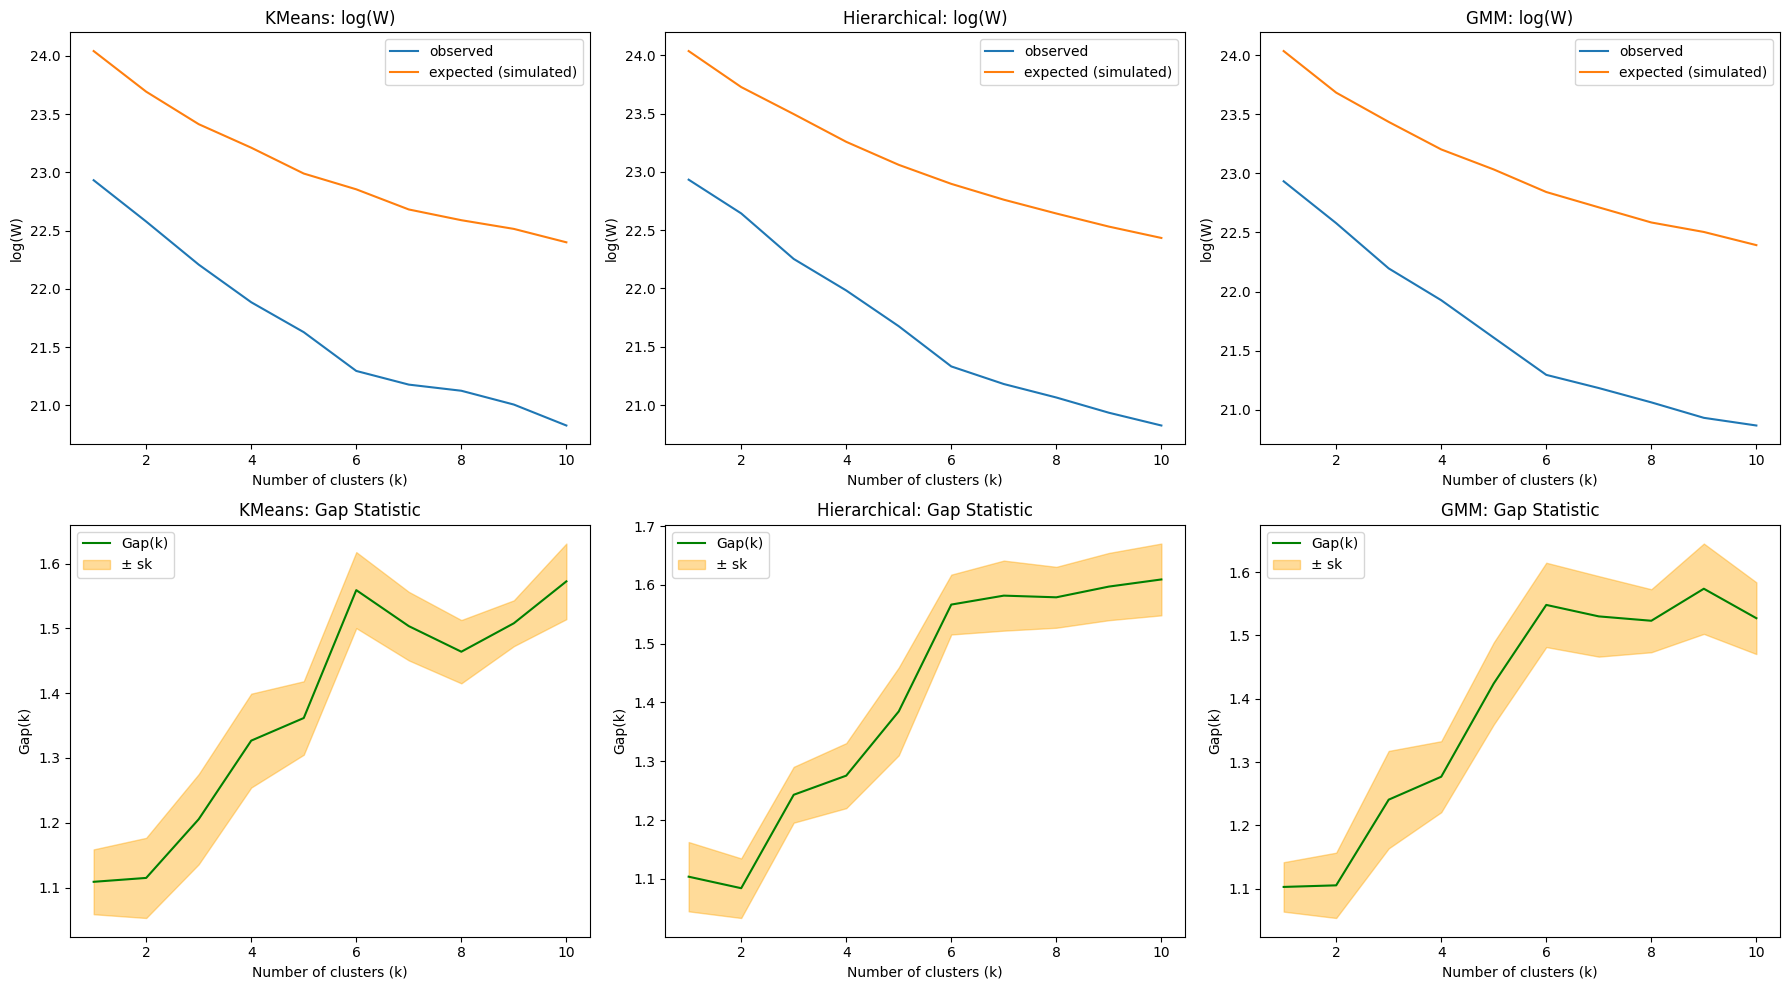

In [8]:
# Datos
df_phys = np.asarray(df_phys)
minX = list(np.min(df_phys, axis=0))
maxX = list(np.max(df_phys, axis=0))
[N, p] = df_phys.shape

clustersNr = 10
list_of_clusters = range(1, clustersNr + 1)
Nsim = 20

# Inicialización de resultados
results = {
    'KMeans': {'W': np.zeros(clustersNr), 'Wu': np.zeros((clustersNr, Nsim))},
    'Hierarchical': {'W': np.zeros(clustersNr), 'Wu': np.zeros((clustersNr, Nsim))},
    'GMM': {'W': np.zeros(clustersNr), 'Wu': np.zeros((clustersNr, Nsim))}
}

# Función para disimilitud intra-clase
def compute_within_class_dissimilarity(X, labels, centers):
    W = 0
    for cluster in np.unique(labels):
        Ik = np.where(labels == cluster)[0]
        dk = np.sum((X[Ik] - centers[cluster])**2, axis=1)
        W += np.sum(dk)
    return W

# Loop principal para los 3 métodos
for method in results.keys():
    for k in list_of_clusters:
        # Clustering real
        if method == 'KMeans':
            model = KMeans(n_clusters=k).fit(df_phys)
            labels = model.labels_
            centers = model.cluster_centers_
        elif method == 'Hierarchical':
            Z = linkage(df_phys, method='ward', metric='euclidean')
            labels = fcluster(Z, t=k, criterion='maxclust') - 1  # hacer 0-based
            centers = np.array([df_phys[labels == i].mean(axis=0) for i in range(k)])
            # usar centroides como promedio de cada grupo
            centers = np.array([df_phys[labels == i].mean(axis=0) for i in range(k)])
        elif method == 'GMM':
            model = GaussianMixture(n_components=k, random_state=42).fit(df_phys)
            labels = model.predict(df_phys)
            centers = model.means_

        results[method]['W'][k-1] = compute_within_class_dissimilarity(df_phys, labels, centers)

        # Simulaciones
        for j in range(Nsim):
            Xu = np.ones((N, 1)) * minX + np.random.rand(N, p) * (np.ones((N, 1)) * (np.array(maxX) - np.array(minX)))

            if method == 'KMeans':
                model_sim = KMeans(n_clusters=k).fit(Xu)
                labels_u = model_sim.labels_
                centers_u = model_sim.cluster_centers_
            elif method == 'Hierarchical':
                model_sim = AgglomerativeClustering(n_clusters=k).fit(Xu)
                labels_u = model_sim.labels_
                centers_u = np.array([Xu[labels_u == i].mean(axis=0) for i in range(k)])
            elif method == 'GMM':
                model_sim = GaussianMixture(n_components=k, random_state=42).fit(Xu)
                labels_u = model_sim.predict(Xu)
                centers_u = model_sim.means_

            results[method]['Wu'][k-1, j] = compute_within_class_dissimilarity(Xu, labels_u, centers_u)

# 📊 Graficar resultados
x_range = np.array(range(clustersNr)) + 1
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for idx, method in enumerate(results.keys()):
    W = results[method]['W']
    Wu = results[method]['Wu']
    Elog_Wu = np.mean(np.log(Wu), axis=1)
    sk = np.std(np.log(Wu), axis=1) * np.sqrt(1 + 1 / Nsim)
    Gk = Elog_Wu - np.log(W)

    # Plot log(W)
    axs[0, idx].plot(x_range, np.log(W), label='observed')
    axs[0, idx].plot(x_range, Elog_Wu, label='expected (simulated)')
    axs[0, idx].set_title(f'{method}: log(W)')
    axs[0, idx].set_xlabel('Number of clusters (k)')
    axs[0, idx].set_ylabel('log(W)')
    axs[0, idx].legend()

    # Plot Gap Statistic
    axs[1, idx].plot(x_range, Gk, color='green', label='Gap(k)')
    axs[1, idx].fill_between(x_range, Gk - sk, Gk + sk, color='orange', alpha=0.4, label='± sk')
    axs[1, idx].set_title(f'{method}: Gap Statistic')
    axs[1, idx].set_xlabel('Number of clusters (k)')
    axs[1, idx].set_ylabel('Gap(k)')
    axs[1, idx].legend()

plt.tight_layout()
plt.show()

### How are the groups based on the emotions?

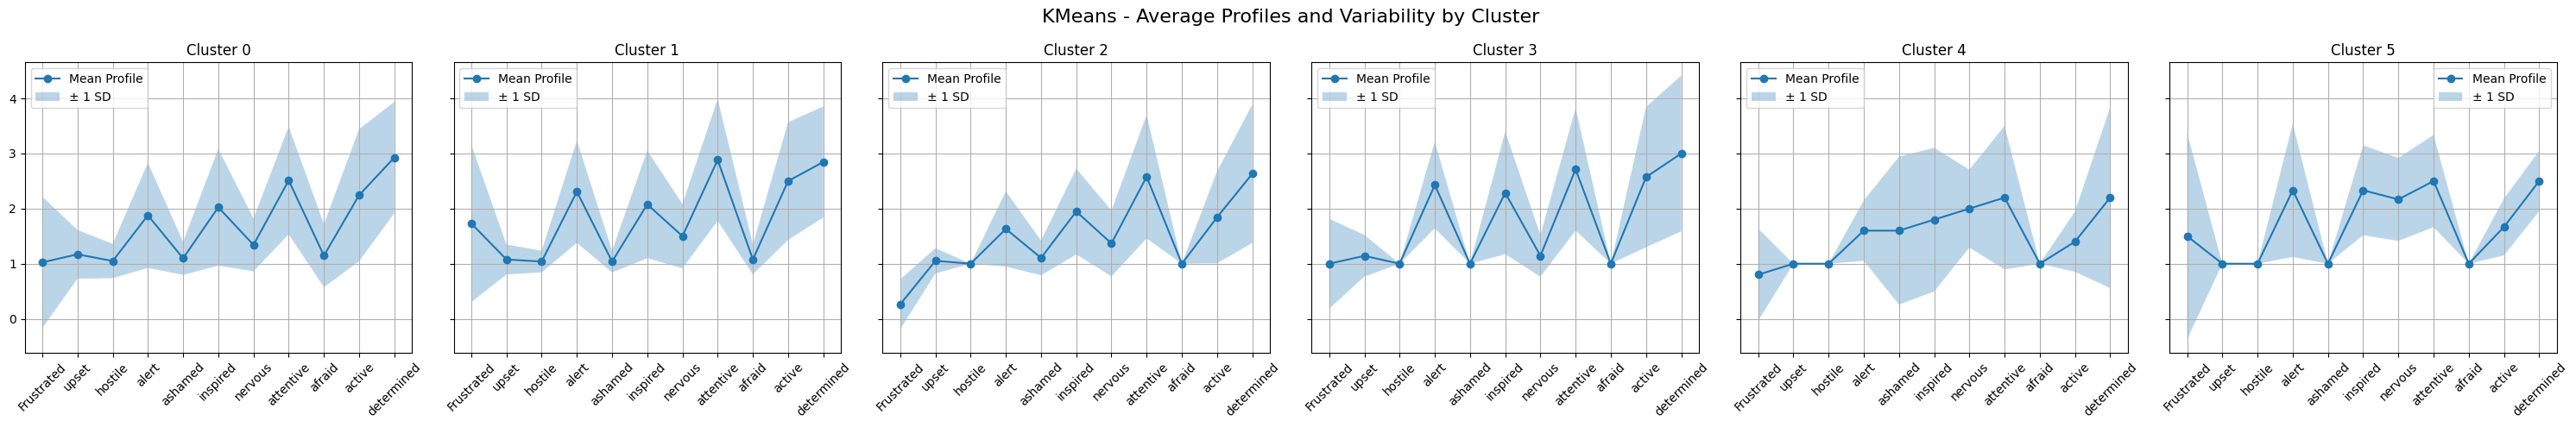

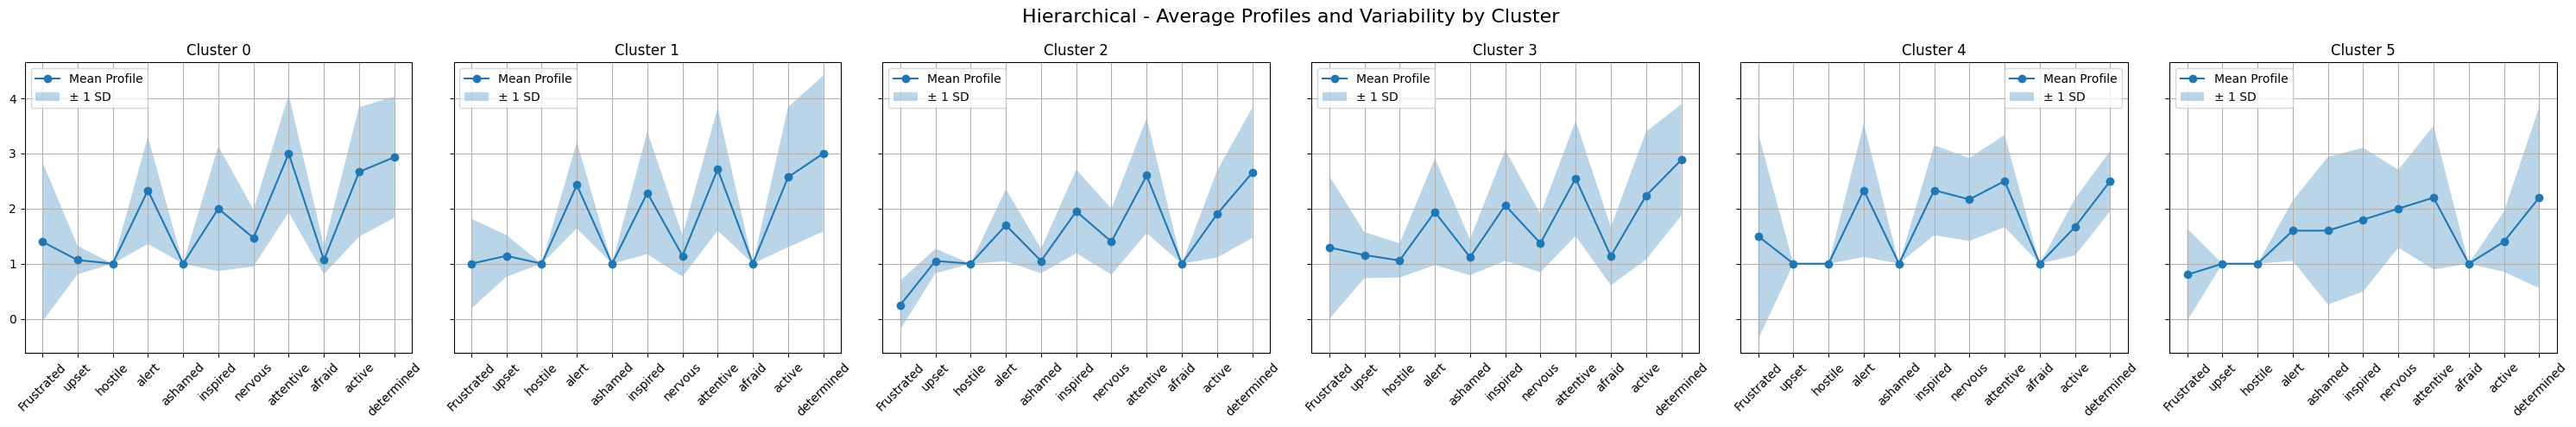

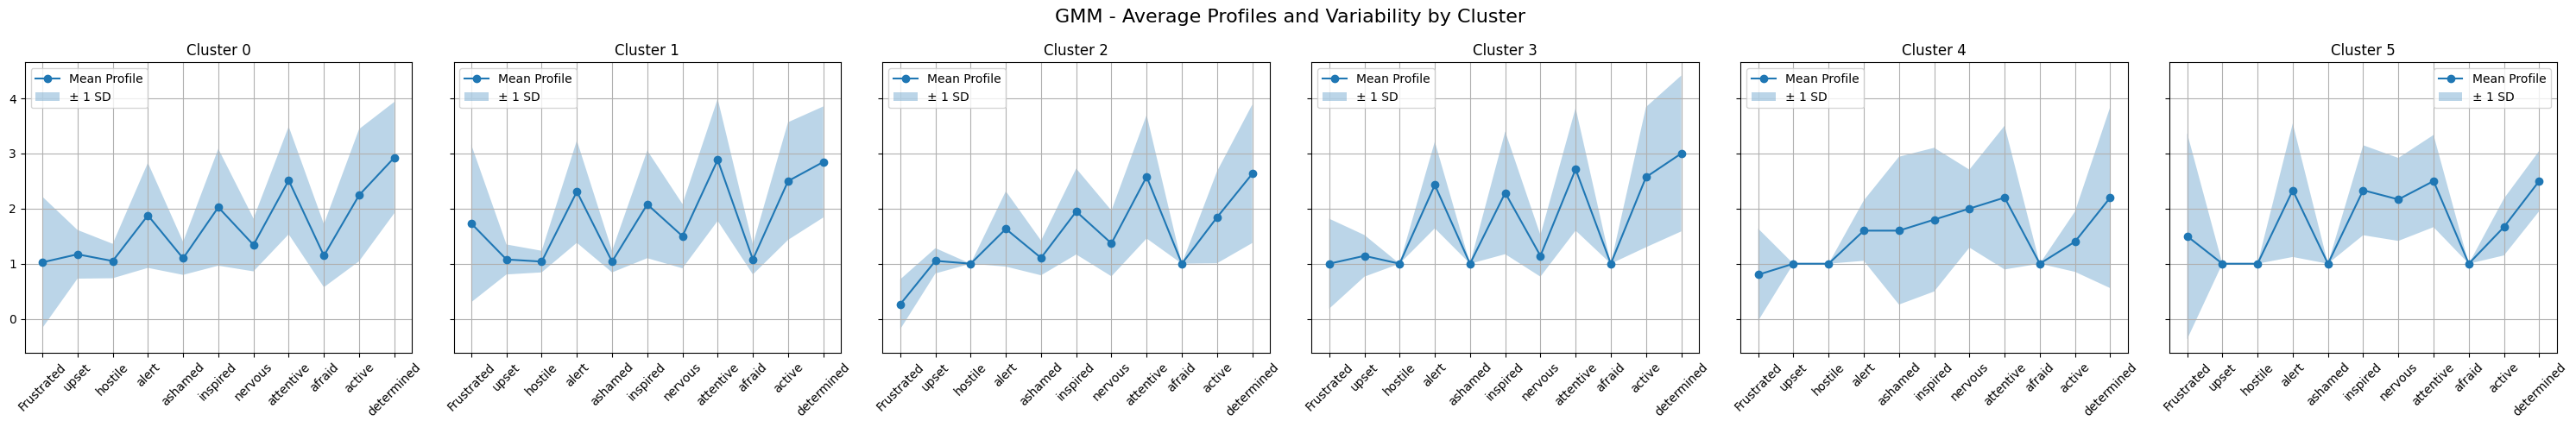

In [11]:
# Asegura que df_emotions esté como DataFrame
df_phys = pd.DataFrame(df_phys, columns=phys_var_columns)

# Diccionario para almacenar etiquetas
cluster_labels = {}

# 1. KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_phys)
cluster_labels['KMeans'] = kmeans.labels_

# 2. Hierarchical clustering (con linkage + fcluster)
Z = linkage(df_phys, method='ward', metric='euclidean')
labels_hier = fcluster(Z, t=6, criterion='maxclust') - 1  # convertir a 0-based
cluster_labels['Hierarchical'] = labels_hier

# 3. GMM clustering
gmm = GaussianMixture(n_components=6, random_state=0).fit(df_phys)
labels_gmm = gmm.predict(df_phys)
cluster_labels['GMM'] = labels_gmm

# 4. Graficar los perfiles por método (con número variable de clusters)
for method, labels in cluster_labels.items():
    df_phys_clustered = df_phase1[emotions_columns].copy()
    df_phys_clustered['Cluster'] = labels

    unique_clusters = np.unique(labels)
    n_clusters_method = len(unique_clusters)

    fig, axs = plt.subplots(1, n_clusters_method, figsize=(5 * n_clusters_method, 5), sharey=True)

    # Si solo hay un cluster, axs no es un array → convertirlo
    if n_clusters_method == 1:
        axs = [axs]

    for i, cluster_id in enumerate(unique_clusters):
        cluster_data = df_phys_clustered[df_phys_clustered['Cluster'] == cluster_id]

        # Perfiles medios y desviación estándar
        mean_profile = cluster_data.iloc[:, :-1].mean()
        std_profile = cluster_data.iloc[:, :-1].std()

        x = np.arange(len(emotions_columns))

        axs[i].plot(x, mean_profile, marker='o', label='Mean Profile')
        axs[i].fill_between(x, mean_profile - std_profile, mean_profile + std_profile,
                            alpha=0.3, label='± 1 SD')

        axs[i].set_title(f'Cluster {cluster_id}')
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(emotions_columns, rotation=45)
        axs[i].grid(True)
        axs[i].legend()

    fig.suptitle(f'{method} - Average Profiles and Variability by Cluster', fontsize=16)
    plt.tight_layout()
    plt.show()



### Repeat with the Phase 2 

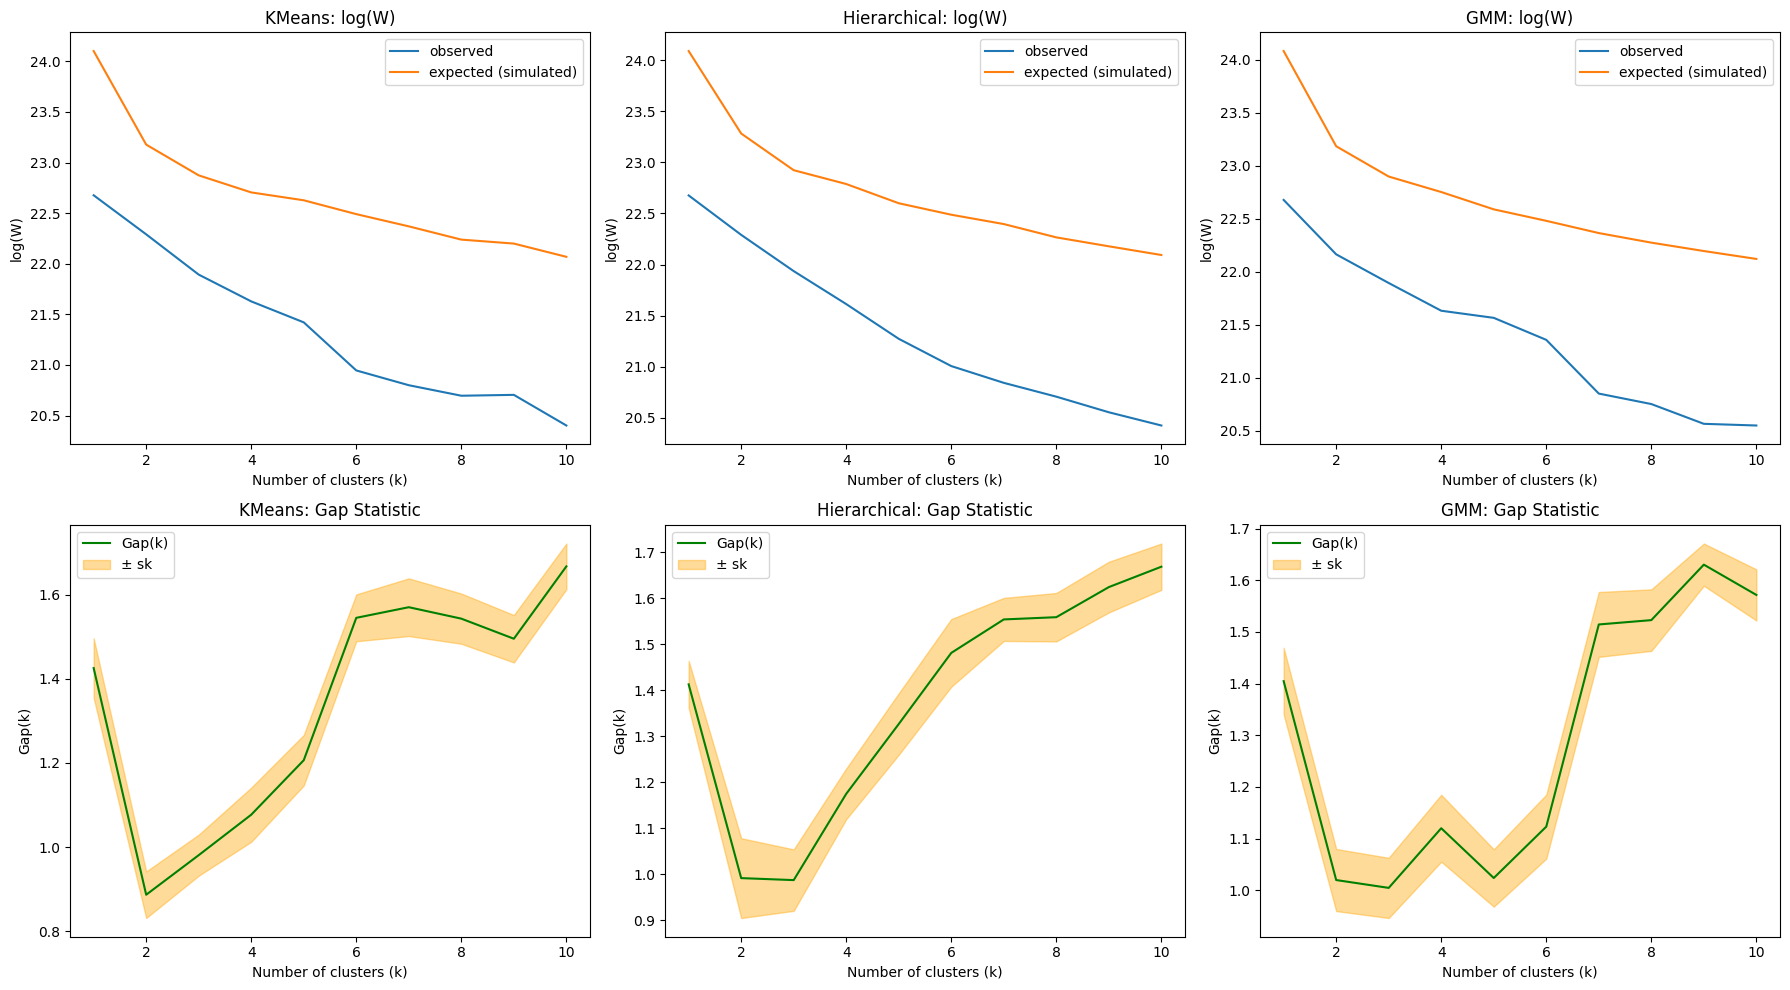

In [12]:
df_phase2 = df[df['Phase'] == 'phase2']

df_phys = df_phase2[phys_var_columns]

# Datos
df_phys = np.asarray(df_phys)
minX = list(np.min(df_phys, axis=0))
maxX = list(np.max(df_phys, axis=0))
[N, p] = df_phys.shape

clustersNr = 10
list_of_clusters = range(1, clustersNr + 1)
Nsim = 20

# Inicialización de resultados
results = {
    'KMeans': {'W': np.zeros(clustersNr), 'Wu': np.zeros((clustersNr, Nsim))},
    'Hierarchical': {'W': np.zeros(clustersNr), 'Wu': np.zeros((clustersNr, Nsim))},
    'GMM': {'W': np.zeros(clustersNr), 'Wu': np.zeros((clustersNr, Nsim))}
}

# Función para disimilitud intra-clase
def compute_within_class_dissimilarity(X, labels, centers):
    W = 0
    for cluster in np.unique(labels):
        Ik = np.where(labels == cluster)[0]
        dk = np.sum((X[Ik] - centers[cluster])**2, axis=1)
        W += np.sum(dk)
    return W

# Loop principal para los 3 métodos
for method in results.keys():
    for k in list_of_clusters:
        # Clustering real
        if method == 'KMeans':
            model = KMeans(n_clusters=k).fit(df_phys)
            labels = model.labels_
            centers = model.cluster_centers_
        elif method == 'Hierarchical':
            Z = linkage(df_phys, method='ward', metric='euclidean')
            labels = fcluster(Z, t=k, criterion='maxclust') - 1  # hacer 0-based
            centers = np.array([df_phys[labels == i].mean(axis=0) for i in range(k)])
            # usar centroides como promedio de cada grupo
            centers = np.array([df_phys[labels == i].mean(axis=0) for i in range(k)])
        elif method == 'GMM':
            model = GaussianMixture(n_components=k, random_state=42).fit(df_phys)
            labels = model.predict(df_phys)
            centers = model.means_

        results[method]['W'][k-1] = compute_within_class_dissimilarity(df_phys, labels, centers)

        # Simulaciones
        for j in range(Nsim):
            Xu = np.ones((N, 1)) * minX + np.random.rand(N, p) * (np.ones((N, 1)) * (np.array(maxX) - np.array(minX)))

            if method == 'KMeans':
                model_sim = KMeans(n_clusters=k).fit(Xu)
                labels_u = model_sim.labels_
                centers_u = model_sim.cluster_centers_
            elif method == 'Hierarchical':
                model_sim = AgglomerativeClustering(n_clusters=k).fit(Xu)
                labels_u = model_sim.labels_
                centers_u = np.array([Xu[labels_u == i].mean(axis=0) for i in range(k)])
            elif method == 'GMM':
                model_sim = GaussianMixture(n_components=k, random_state=42).fit(Xu)
                labels_u = model_sim.predict(Xu)
                centers_u = model_sim.means_

            results[method]['Wu'][k-1, j] = compute_within_class_dissimilarity(Xu, labels_u, centers_u)

# 📊 Graficar resultados
x_range = np.array(range(clustersNr)) + 1
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for idx, method in enumerate(results.keys()):
    W = results[method]['W']
    Wu = results[method]['Wu']
    Elog_Wu = np.mean(np.log(Wu), axis=1)
    sk = np.std(np.log(Wu), axis=1) * np.sqrt(1 + 1 / Nsim)
    Gk = Elog_Wu - np.log(W)

    # Plot log(W)
    axs[0, idx].plot(x_range, np.log(W), label='observed')
    axs[0, idx].plot(x_range, Elog_Wu, label='expected (simulated)')
    axs[0, idx].set_title(f'{method}: log(W)')
    axs[0, idx].set_xlabel('Number of clusters (k)')
    axs[0, idx].set_ylabel('log(W)')
    axs[0, idx].legend()

    # Plot Gap Statistic
    axs[1, idx].plot(x_range, Gk, color='green', label='Gap(k)')
    axs[1, idx].fill_between(x_range, Gk - sk, Gk + sk, color='orange', alpha=0.4, label='± sk')
    axs[1, idx].set_title(f'{method}: Gap Statistic')
    axs[1, idx].set_xlabel('Number of clusters (k)')
    axs[1, idx].set_ylabel('Gap(k)')
    axs[1, idx].legend()

plt.tight_layout()
plt.show()

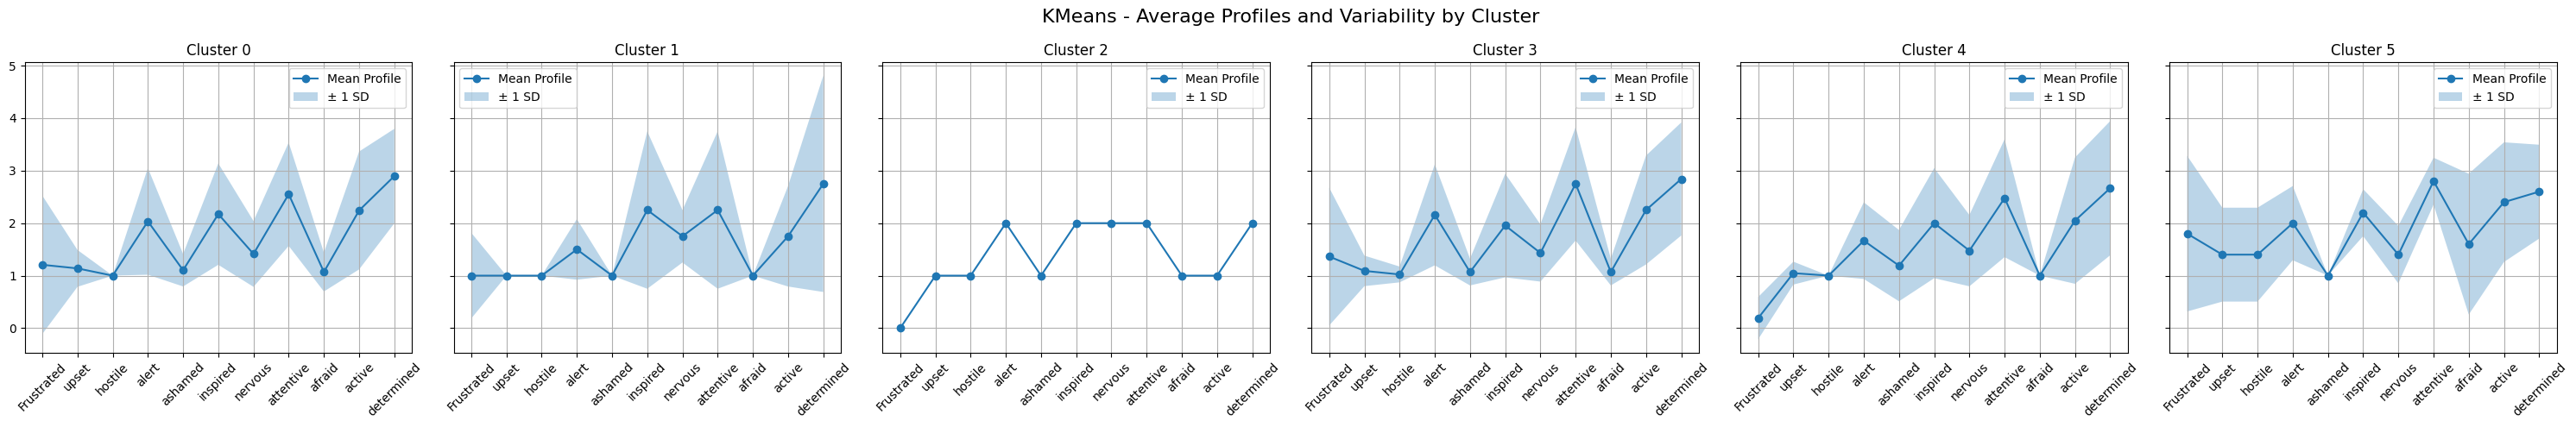

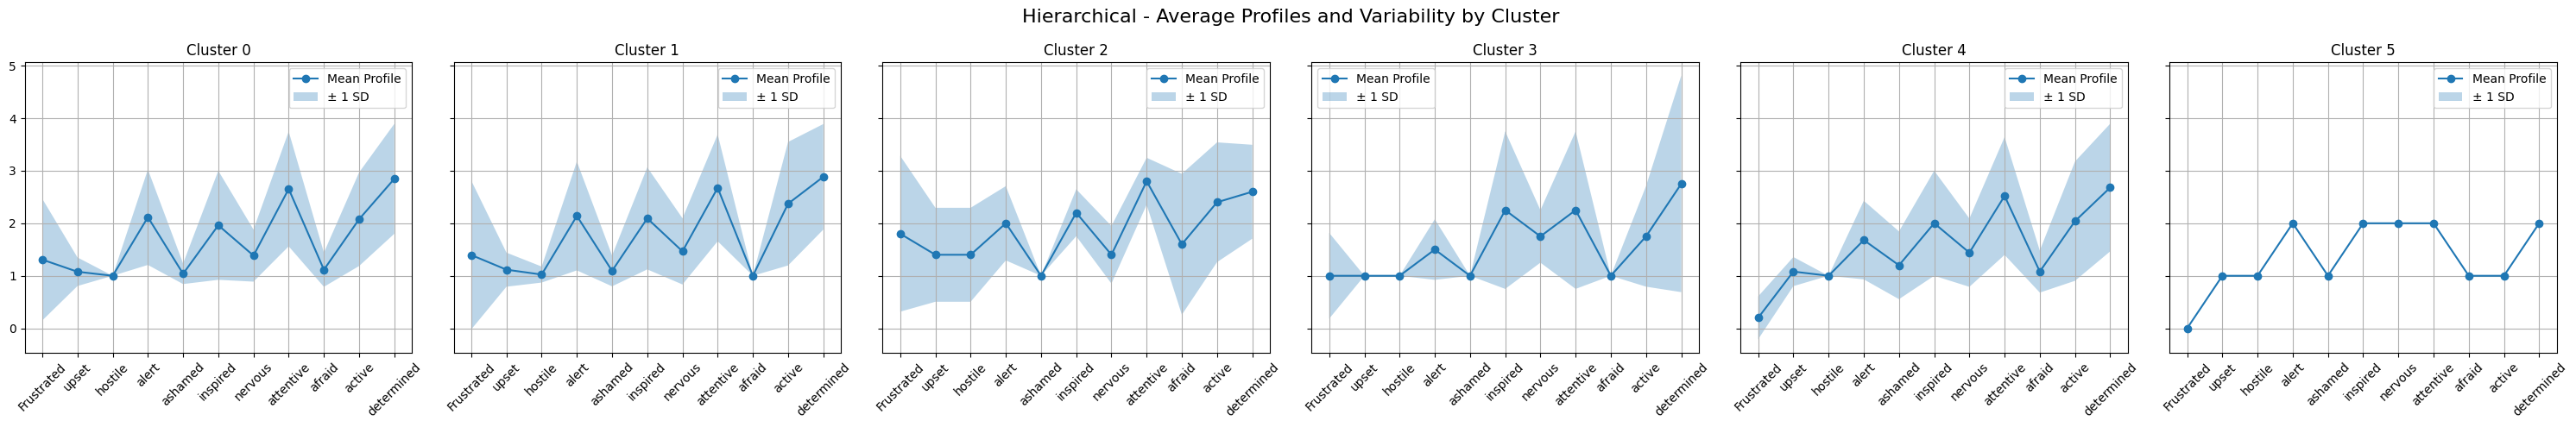

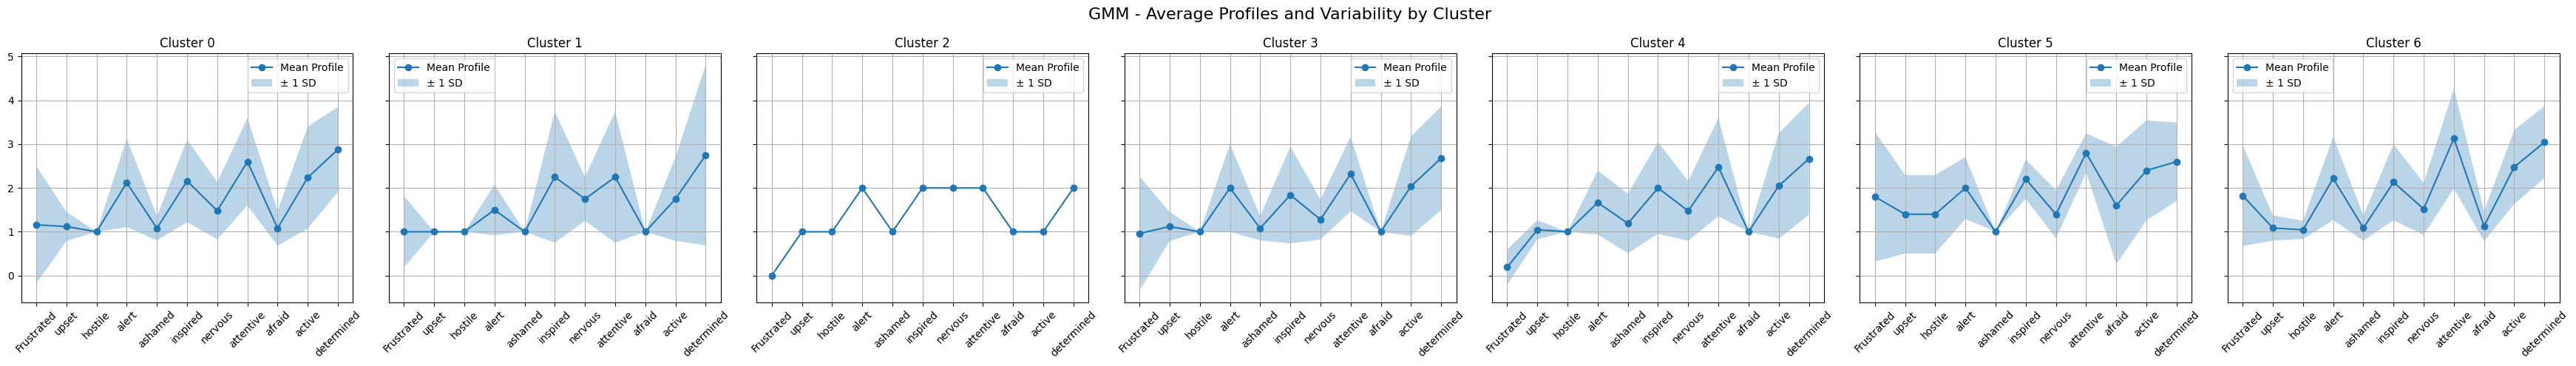

In [13]:
# Asegura que df_emotions esté como DataFrame
df_phys = pd.DataFrame(df_phys, columns=phys_var_columns)

# Diccionario para almacenar etiquetas
cluster_labels = {}

# 1. KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_phys)
cluster_labels['KMeans'] = kmeans.labels_

# 2. Hierarchical clustering (con linkage + fcluster)
Z = linkage(df_phys, method='ward', metric='euclidean')
labels_hier = fcluster(Z, t=6, criterion='maxclust') - 1  # convertir a 0-based
cluster_labels['Hierarchical'] = labels_hier

# 3. GMM clustering
gmm = GaussianMixture(n_components=7, random_state=0).fit(df_phys)
labels_gmm = gmm.predict(df_phys)
cluster_labels['GMM'] = labels_gmm

# 4. Graficar los perfiles por método (con número variable de clusters)
for method, labels in cluster_labels.items():
    df_phys_clustered = df_phase1[emotions_columns].copy()
    df_phys_clustered['Cluster'] = labels

    unique_clusters = np.unique(labels)
    n_clusters_method = len(unique_clusters)

    fig, axs = plt.subplots(1, n_clusters_method, figsize=(5 * n_clusters_method, 5), sharey=True)

    # Si solo hay un cluster, axs no es un array → convertirlo
    if n_clusters_method == 1:
        axs = [axs]

    for i, cluster_id in enumerate(unique_clusters):
        cluster_data = df_phys_clustered[df_phys_clustered['Cluster'] == cluster_id]

        # Perfiles medios y desviación estándar
        mean_profile = cluster_data.iloc[:, :-1].mean()
        std_profile = cluster_data.iloc[:, :-1].std()

        x = np.arange(len(emotions_columns))

        axs[i].plot(x, mean_profile, marker='o', label='Mean Profile')
        axs[i].fill_between(x, mean_profile - std_profile, mean_profile + std_profile,
                            alpha=0.3, label='± 1 SD')

        axs[i].set_title(f'Cluster {cluster_id}')
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(emotions_columns, rotation=45)
        axs[i].grid(True)
        axs[i].legend()

    fig.suptitle(f'{method} - Average Profiles and Variability by Cluster', fontsize=16)
    plt.tight_layout()
    plt.show()


### Repeat for the phase 3

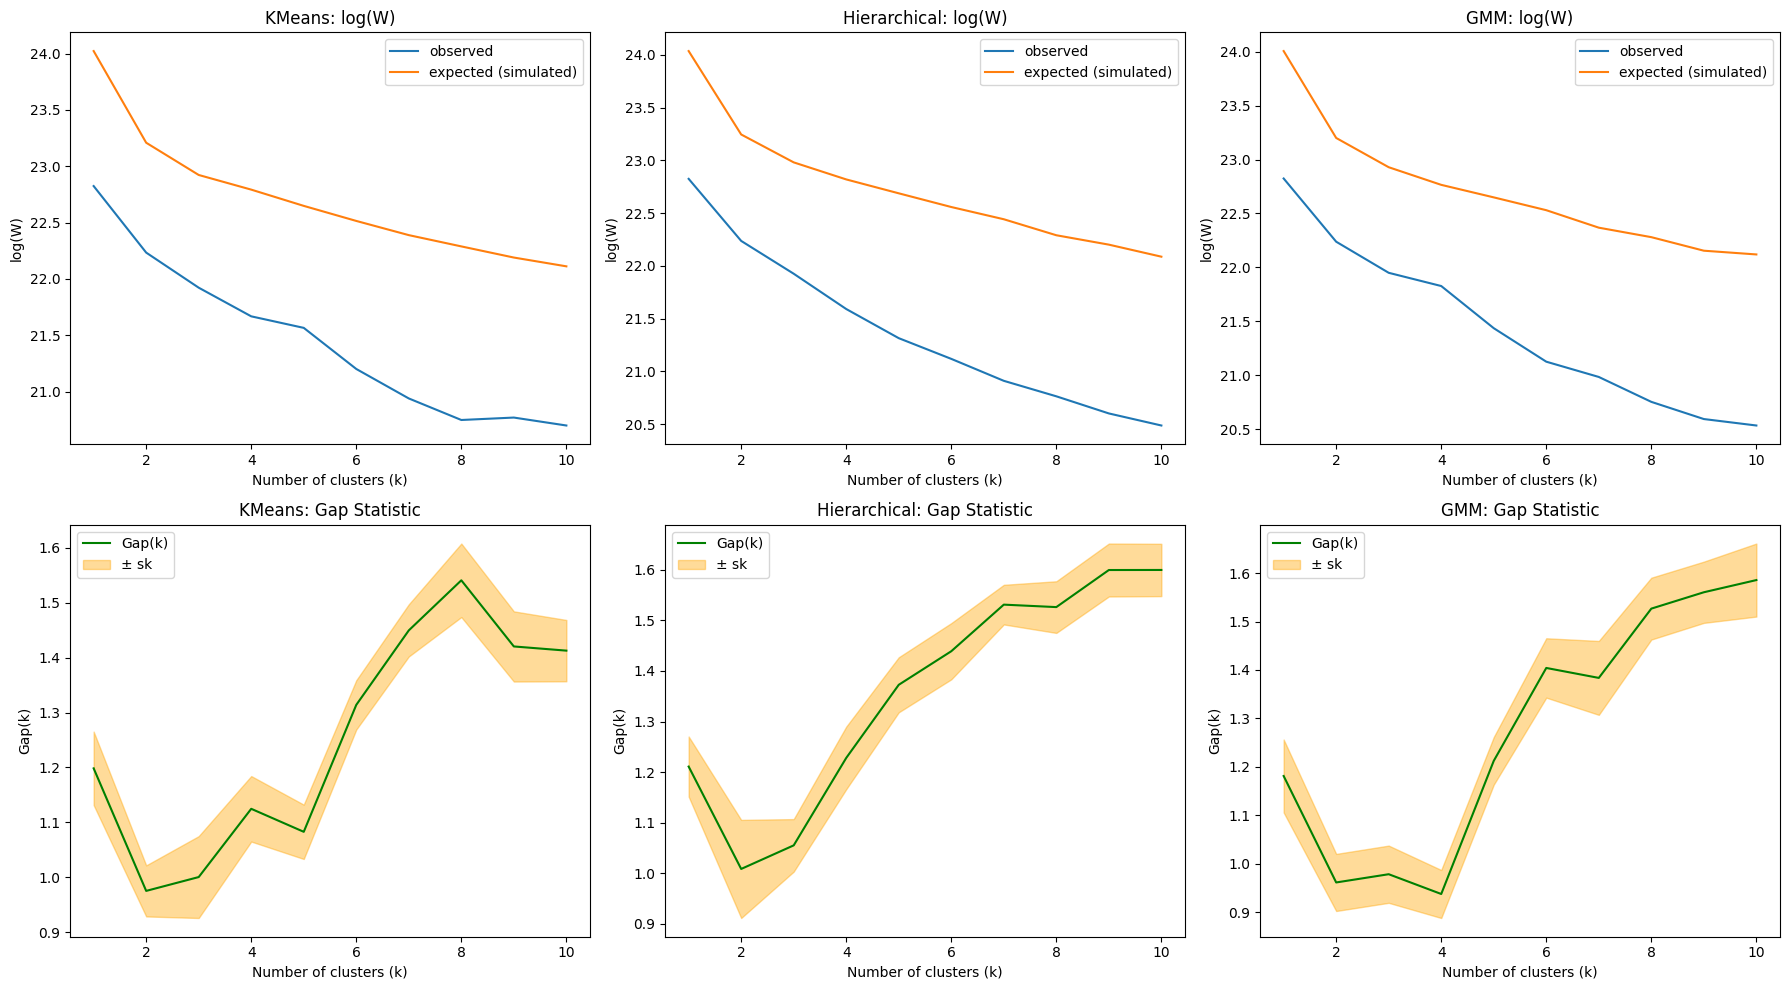

In [14]:
df_phase3 = df[df['Phase'] == 'phase3']

df_phys = df_phase3[phys_var_columns]

# Datos
df_phys = np.asarray(df_phys)
minX = list(np.min(df_phys, axis=0))
maxX = list(np.max(df_phys, axis=0))
[N, p] = df_phys.shape

clustersNr = 10
list_of_clusters = range(1, clustersNr + 1)
Nsim = 20

# Inicialización de resultados
results = {
    'KMeans': {'W': np.zeros(clustersNr), 'Wu': np.zeros((clustersNr, Nsim))},
    'Hierarchical': {'W': np.zeros(clustersNr), 'Wu': np.zeros((clustersNr, Nsim))},
    'GMM': {'W': np.zeros(clustersNr), 'Wu': np.zeros((clustersNr, Nsim))}
}

# Función para disimilitud intra-clase
def compute_within_class_dissimilarity(X, labels, centers):
    W = 0
    for cluster in np.unique(labels):
        Ik = np.where(labels == cluster)[0]
        dk = np.sum((X[Ik] - centers[cluster])**2, axis=1)
        W += np.sum(dk)
    return W

# Loop principal para los 3 métodos
for method in results.keys():
    for k in list_of_clusters:
        # Clustering real
        if method == 'KMeans':
            model = KMeans(n_clusters=k).fit(df_phys)
            labels = model.labels_
            centers = model.cluster_centers_
        elif method == 'Hierarchical':
            Z = linkage(df_phys, method='ward', metric='euclidean')
            labels = fcluster(Z, t=k, criterion='maxclust') - 1  # hacer 0-based
            centers = np.array([df_phys[labels == i].mean(axis=0) for i in range(k)])
            # usar centroides como promedio de cada grupo
            centers = np.array([df_phys[labels == i].mean(axis=0) for i in range(k)])
        elif method == 'GMM':
            model = GaussianMixture(n_components=k, random_state=42).fit(df_phys)
            labels = model.predict(df_phys)
            centers = model.means_

        results[method]['W'][k-1] = compute_within_class_dissimilarity(df_phys, labels, centers)

        # Simulaciones
        for j in range(Nsim):
            Xu = np.ones((N, 1)) * minX + np.random.rand(N, p) * (np.ones((N, 1)) * (np.array(maxX) - np.array(minX)))

            if method == 'KMeans':
                model_sim = KMeans(n_clusters=k).fit(Xu)
                labels_u = model_sim.labels_
                centers_u = model_sim.cluster_centers_
            elif method == 'Hierarchical':
                model_sim = AgglomerativeClustering(n_clusters=k).fit(Xu)
                labels_u = model_sim.labels_
                centers_u = np.array([Xu[labels_u == i].mean(axis=0) for i in range(k)])
            elif method == 'GMM':
                model_sim = GaussianMixture(n_components=k, random_state=42).fit(Xu)
                labels_u = model_sim.predict(Xu)
                centers_u = model_sim.means_

            results[method]['Wu'][k-1, j] = compute_within_class_dissimilarity(Xu, labels_u, centers_u)

# 📊 Graficar resultados
x_range = np.array(range(clustersNr)) + 1
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for idx, method in enumerate(results.keys()):
    W = results[method]['W']
    Wu = results[method]['Wu']
    Elog_Wu = np.mean(np.log(Wu), axis=1)
    sk = np.std(np.log(Wu), axis=1) * np.sqrt(1 + 1 / Nsim)
    Gk = Elog_Wu - np.log(W)

    # Plot log(W)
    axs[0, idx].plot(x_range, np.log(W), label='observed')
    axs[0, idx].plot(x_range, Elog_Wu, label='expected (simulated)')
    axs[0, idx].set_title(f'{method}: log(W)')
    axs[0, idx].set_xlabel('Number of clusters (k)')
    axs[0, idx].set_ylabel('log(W)')
    axs[0, idx].legend()

    # Plot Gap Statistic
    axs[1, idx].plot(x_range, Gk, color='green', label='Gap(k)')
    axs[1, idx].fill_between(x_range, Gk - sk, Gk + sk, color='orange', alpha=0.4, label='± sk')
    axs[1, idx].set_title(f'{method}: Gap Statistic')
    axs[1, idx].set_xlabel('Number of clusters (k)')
    axs[1, idx].set_ylabel('Gap(k)')
    axs[1, idx].legend()

plt.tight_layout()
plt.show()

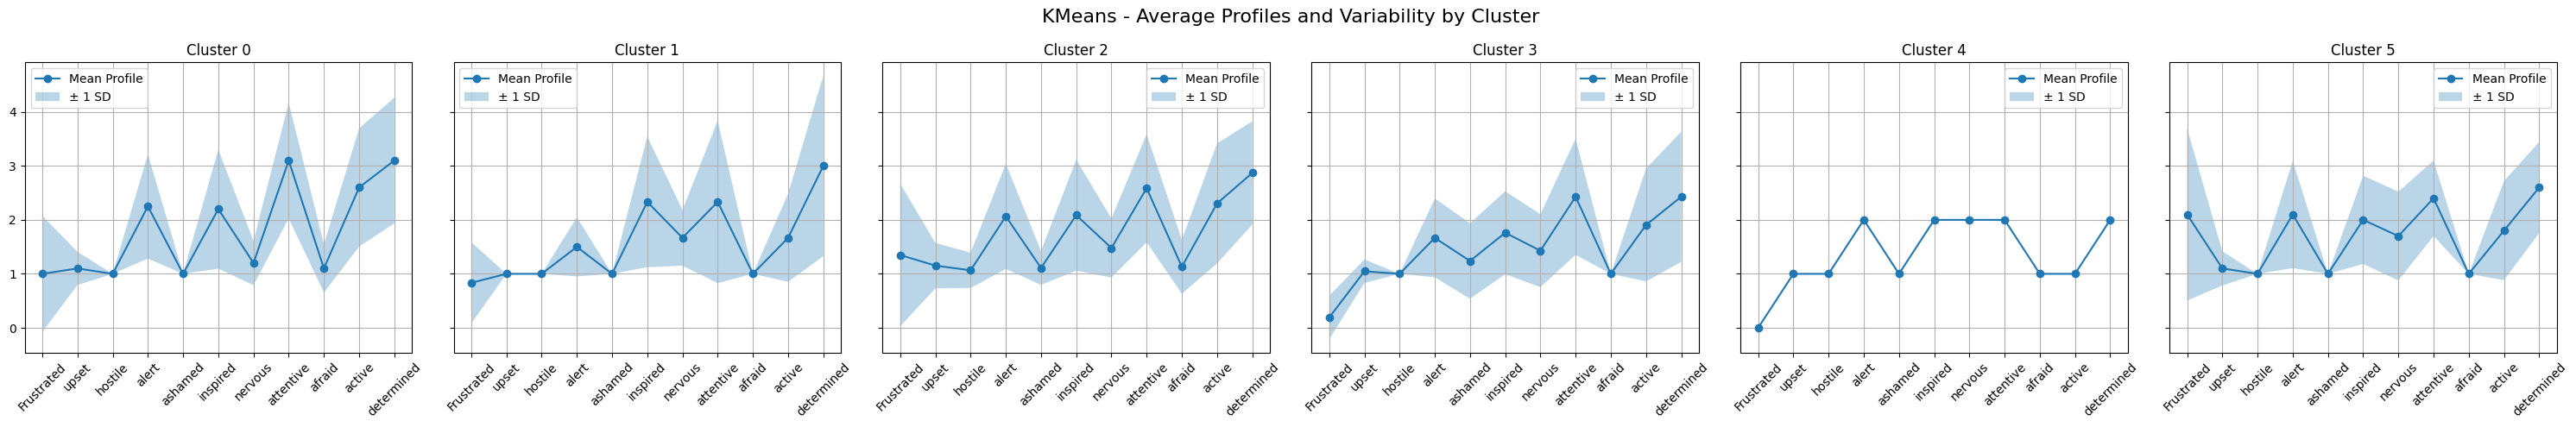

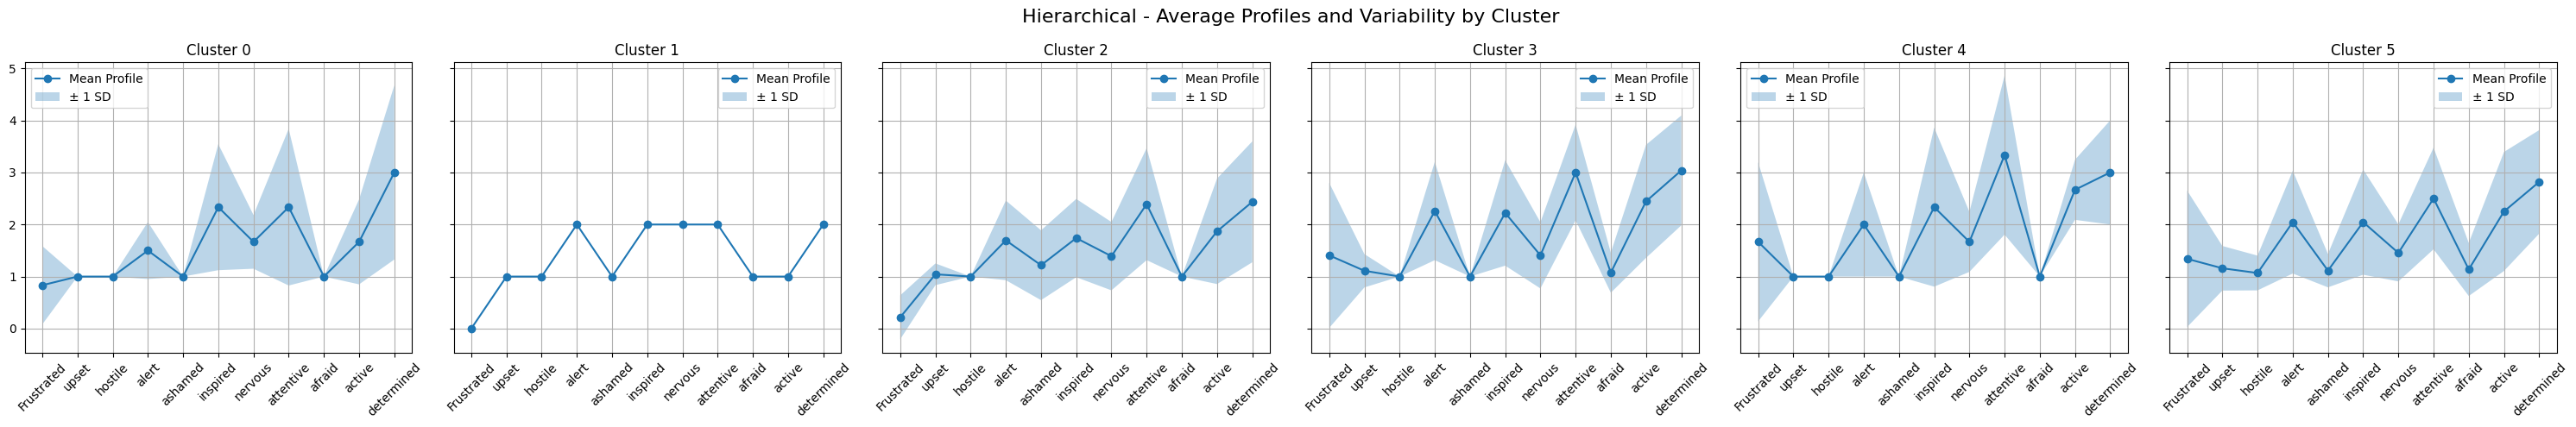

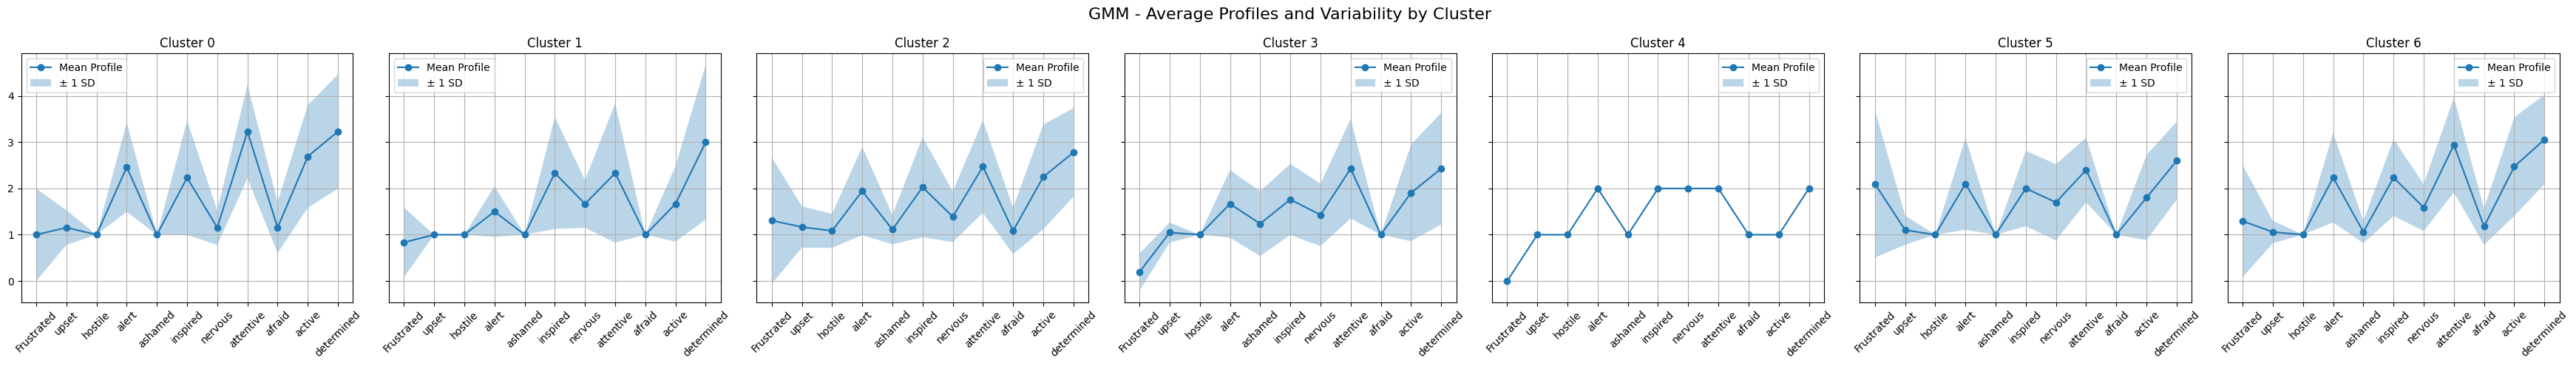

In [15]:
# Asegura que df_emotions esté como DataFrame
df_phys = pd.DataFrame(df_phys, columns=phys_var_columns)

# Diccionario para almacenar etiquetas
cluster_labels = {}

# 1. KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_phys)
cluster_labels['KMeans'] = kmeans.labels_

# 2. Hierarchical clustering (con linkage + fcluster)
Z = linkage(df_phys, method='ward', metric='euclidean')
labels_hier = fcluster(Z, t=6, criterion='maxclust') - 1  # convertir a 0-based
cluster_labels['Hierarchical'] = labels_hier

# 3. GMM clustering
gmm = GaussianMixture(n_components=7, random_state=0).fit(df_phys)
labels_gmm = gmm.predict(df_phys)
cluster_labels['GMM'] = labels_gmm

# 4. Graficar los perfiles por método (con número variable de clusters)
for method, labels in cluster_labels.items():
    df_phys_clustered = df_phase1[emotions_columns].copy()
    df_phys_clustered['Cluster'] = labels

    unique_clusters = np.unique(labels)
    n_clusters_method = len(unique_clusters)

    fig, axs = plt.subplots(1, n_clusters_method, figsize=(5 * n_clusters_method, 5), sharey=True)

    # Si solo hay un cluster, axs no es un array → convertirlo
    if n_clusters_method == 1:
        axs = [axs]

    for i, cluster_id in enumerate(unique_clusters):
        cluster_data = df_phys_clustered[df_phys_clustered['Cluster'] == cluster_id]

        # Perfiles medios y desviación estándar
        mean_profile = cluster_data.iloc[:, :-1].mean()
        std_profile = cluster_data.iloc[:, :-1].std()

        x = np.arange(len(emotions_columns))

        axs[i].plot(x, mean_profile, marker='o', label='Mean Profile')
        axs[i].fill_between(x, mean_profile - std_profile, mean_profile + std_profile,
                            alpha=0.3, label='± 1 SD')

        axs[i].set_title(f'Cluster {cluster_id}')
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(emotions_columns, rotation=45)
        axs[i].grid(True)
        axs[i].legend()

    fig.suptitle(f'{method} - Average Profiles and Variability by Cluster', fontsize=16)
    plt.tight_layout()
    plt.show()

# See changes intra patients

In [16]:
# Load (again) data
df = pd.read_csv('../data/HR_data_preprocessed.csv')

emotions_columns = ["Frustrated","upset","hostile","alert","ashamed","inspired","nervous","attentive","afraid","active","determined"]

df_phase1 = df[df['Phase'] == 'phase1']
df_phase2 = df[df['Phase'] == 'phase2']
df_phase3 = df[df['Phase'] == 'phase3']

In [17]:
df_phase1_clean = df_phase1.dropna()
df_emotions1 = df_phase1_clean[emotions_columns]
kmeans1 = KMeans(n_clusters=5, random_state=0).fit(df_emotions1)
df_phase1['cluster_phase1'] = np.nan
df_phase1.loc[df_phase1_clean.index, 'cluster_phase1'] = kmeans1.labels_

df_phase2_clean = df_phase2.dropna()
df_emotions2 = df_phase2_clean[emotions_columns]
kmeans2 = KMeans(n_clusters=6, random_state=0).fit(df_emotions2)
df_phase2['cluster_phase2'] = np.nan
df_phase2.loc[df_phase2_clean.index, 'cluster_phase2'] = kmeans2.labels_

df_phase3_clean = df_phase3.dropna()
df_emotions3 = df_phase3_clean[emotions_columns]
kmeans3 = KMeans(n_clusters=3, random_state=0).fit(df_emotions3)
df_phase3['cluster_phase3'] = np.nan
df_phase3.loc[df_phase3_clean.index, 'cluster_phase3'] = kmeans3.labels_

# First merge phase1 and phase2
df_temp = pd.merge(
    df_phase1[['Individual', 'cluster_phase1', 'Phase']],
    df_phase2[['Individual', 'cluster_phase2', 'Phase']],
    on='Individual',
    how='outer'
)

# Then merge the result with phase3
df_merged = pd.merge(
    df_temp,
    df_phase3[['Individual', 'cluster_phase3', 'Phase']],
    on='Individual',
    how='outer'
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_28724\1722841675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_phase1['cluster_phase1'] = np.nan
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28724\1722841675.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_phase2['cluster_phase2'] = np.nan
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28724\1722841675.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

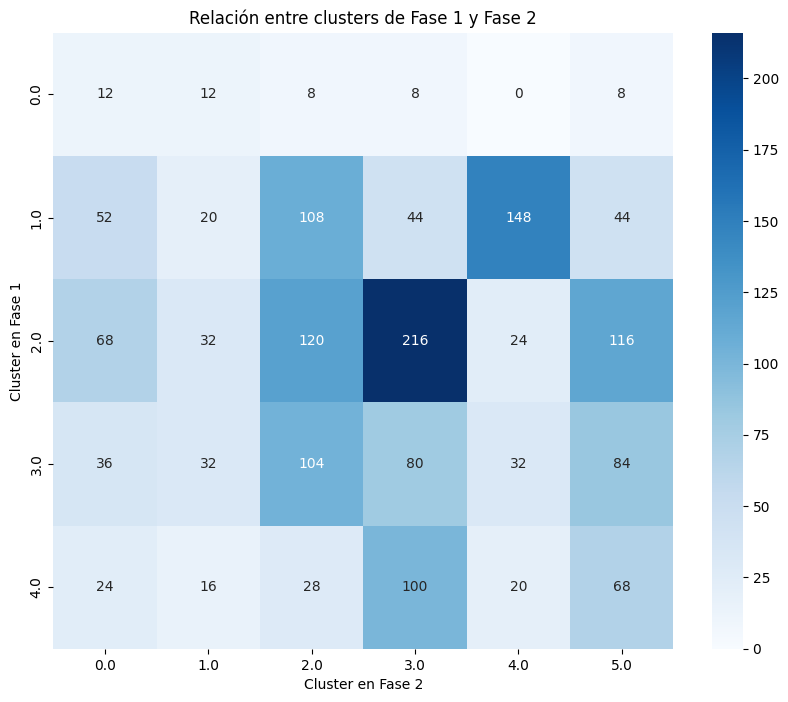

In [18]:
# Suponiendo que tu DataFrame se llama df
# Creamos una tabla de conteos entre cluster de fase1 y fase2
confusion = pd.crosstab(df_merged['cluster_phase1'], df_merged['cluster_phase2'])

# Graficamos
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.title('Relación entre clusters de Fase 1 y Fase 2')
plt.xlabel('Cluster en Fase 2')
plt.ylabel('Cluster en Fase 1')
plt.show()

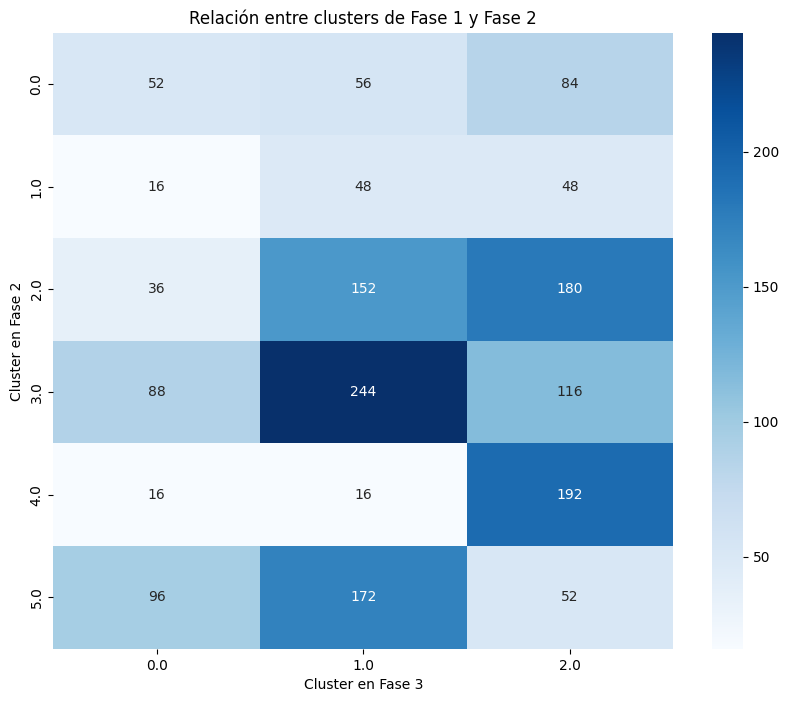

In [19]:
# Suponiendo que tu DataFrame se llama df
# Creamos una tabla de conteos entre cluster de fase1 y fase2
confusion = pd.crosstab(df_merged['cluster_phase2'], df_merged['cluster_phase3'])

# Graficamos
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.title('Relación entre clusters de Fase 1 y Fase 2')
plt.xlabel('Cluster en Fase 3')
plt.ylabel('Cluster en Fase 2')
plt.show()

In [20]:
import plotly.graph_objects as go

df = df_merged

# Primero contamos las transiciones entre fase 1 -> fase 2
transitions_12 = df.groupby(['cluster_phase1', 'cluster_phase2']).size().reset_index(name='count')

# Luego contamos las transiciones entre fase 2 -> fase 3
transitions_23 = df.groupby(['cluster_phase2', 'cluster_phase3']).size().reset_index(name='count')

# Crear las listas necesarias para el Sankey
max_phase1 = int(df['cluster_phase1'].max()) + 1
max_phase2 = int(df['cluster_phase2'].max()) + 1

# Para fase1 -> fase2
source_12 = transitions_12['cluster_phase1'].astype(int)
target_12 = transitions_12['cluster_phase2'].astype(int) + max_phase1  # desplazamos para no solaparlos
value_12 = transitions_12['count']

# Para fase2 -> fase3
source_23 = transitions_23['cluster_phase2'].astype(int) + max_phase1
target_23 = transitions_23['cluster_phase3'].astype(int) + max_phase1 + max_phase2
value_23 = transitions_23['count']

# Unimos todo
source = pd.concat([source_12, source_23])
target = pd.concat([target_12, target_23])
values = pd.concat([value_12, value_23])

# Crear las etiquetas
labels = (
    [f'Fase1 Cluster {i}' for i in sorted(df['cluster_phase1'].dropna().unique())] +
    [f'Fase2 Cluster {i}' for i in sorted(df['cluster_phase2'].dropna().unique())] +
    [f'Fase3 Cluster {i}' for i in sorted(df['cluster_phase3'].dropna().unique())]
)

# Crear el diagrama de Sankey
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels
    ),
    link = dict(
      source = source,
      target = target,
      value = values
    ))])

fig.update_layout(title_text="Flujo de Pacientes entre Clusters Fase 1, Fase 2 y Fase 3", font_size=10)
fig.show()
